In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence
from skopt import gp_minimize

In [2]:
# Importing the composition and properties database
db = pd.read_csv('FeNiCo_comp-prop.csv')
db = db.iloc[:,1:]
db.head()

,Fe,Co,Ni,V,Mo,Cr,Cu,Mn,C,W,...,Si,Ms,Hc,Tc,ER,TS,YS,Elong,HV,Cost
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.23,NaN,724.0,8.56,NaN,NaN,NaN,NaN,0.42
1,99.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.24,NaN,739.0,11.90,NaN,NaN,NaN,NaN,0.77
2,98.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.25,NaN,753.0,14.13,NaN,NaN,NaN,NaN,1.11
3,97.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.26,NaN,767.0,15.94,NaN,NaN,NaN,NaN,1.45
4,96.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.27,NaN,780.0,17.64,NaN,NaN,NaN,NaN,1.79


In [3]:
# information about the database
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      907 non-null    float64
 16  Hc      602 non-null    float64
 17  Tc      874 non-null    float64
 18  ER      421 non-null    float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   246 non-null    float64
 22  

In [4]:
# Extracting Tensile Strength and Vickers Hardness to a new dataframe
df = pd.concat([db.iloc[:,19],db.iloc[:,22]],axis=1)
df.head()

,TS,HV
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [5]:
# information about the database
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TS      244 non-null    float64
 1   HV      175 non-null    float64
dtypes: float64(2)
memory usage: 19.0 KB


In [6]:
# Droping all the rows with empty Ms and storing into a new dataframe
full_df = df.dropna()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 202 to 1162
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TS      106 non-null    float64
 1   HV      106 non-null    float64
dtypes: float64(2)
memory usage: 2.5 KB


In [7]:
# Defining the features dataframe
X = pd.DataFrame(np.log10(full_df.iloc[:,0]))
X.head()

,TS
202,2.614897
222,3.079904
247,2.697229
280,2.753583
302,2.650308


In [8]:
# Defining the response dataframe
y = pd.DataFrame(np.log10(full_df.iloc[:,-1]))
y.head()

,HV
202,2.000000
222,2.481443
247,1.977724
280,2.103804
302,2.000000


In [9]:
# Standard Scaling the features dataframe
scalerX = StandardScaler()

X_transform = pd.DataFrame(scalerX.fit_transform(X), columns = X.columns)

In [10]:
# Standard Scaling the response dataframe
scalerY = StandardScaler()

y_transform = pd.DataFrame(scalerY.fit_transform(y), columns = y.columns)

In [11]:
# Creating an array of feature names
features = X.columns.values
features

array(['TS'], dtype=object)

In [12]:
# Creating an array of response names
response = y.columns.values
response

array(['HV'], dtype=object)

In [13]:
# Splitting the features and response dataframes into training and testing dataframes
X_train, X_test, y_train, y_test = train_test_split(X_transform, y_transform, test_size=0.2, random_state=0)

In [14]:
from sklearn import metrics

# Function to return the mean of the metric for a particular metric name
def metrics_mean(y_ac, y_pred, metric):
    scores = []
    if metric == 'rmse':
        score = round(np.sqrt(metrics.mean_squared_error(y_ac, y_pred)),3)
    elif metric == 'mae':
        score = round(metrics.mean_absolute_error(y_ac, y_pred),3)
    elif metric == 'R2':
        score = round(metrics.r2_score(y_ac, y_pred),3)
    else:
        score = np.inf
    scores.append(score)
    return np.mean(scores)

# Final function "plot" to plot the train-train predicted values, test-test predicted values and the metrics for
# each ML algorithm used
def plot(regressor_name, y_train, y_train_pred, y_test, y_test_pred):

    y_train = scalerY.inverse_transform(y_train)
    y_train_pred = scalerY.inverse_transform(y_train_pred)
    y_test = scalerY.inverse_transform(y_test)
    y_test_pred = scalerY.inverse_transform(y_test_pred)
    
    plt.figure(figsize = (14,6))
    
    # First subplot - training set
    ax1 = plt.subplot(121)
    
    # plot "predicted values vs actual values and true predictions" graph for train set using first prediction
    y_pred_train = pd.DataFrame(y_train_pred)
    plt.scatter(y_train,y_pred_train)
    plt.plot(y_train,y_train,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_train,y_pred_train,'rmse')  
    mae = metrics_mean(y_train,y_pred_train,'mae')
    R2 = metrics_mean(y_train,y_pred_train,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' training set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
   
    # Second subplot - test set
    ax2 = plt.subplot(122)
    
    # plot "predicted values vs actual values and true predictions" graph for test set using first prediction
    y_pred_test = pd.DataFrame(y_test_pred)
    plt.scatter(y_test,y_pred_test)
    plt.plot(y_test,y_test,'k--',lw=3)
    
    plt.xlabel('True Value',fontsize=16)
    plt.ylabel('Predicted Value',fontsize=16)
    
    # calculate means of the metrics
    rmse = metrics_mean(y_test,y_pred_test,'rmse')  
    mae = metrics_mean(y_test,y_pred_test,'mae')
    R2 = metrics_mean(y_test,y_pred_test,'R2')
    
    # regressor name with all metrics in the title
    plt.title(regressor_name+' test set'
              +'\nRMSE: '+str(rmse)
              +'\nMAE: '+str(mae)
              +'\nR2: '+str(R2),fontsize=16)
    
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
    
    plt.show()

    # return metrics for test set to record the errors across different algorithms
    return rmse, mae, R2

In [15]:
# Defining empty RMSE, MAE, and R2 dictionaries to store the metrics of each regressor
rmse_scores = {}
mae_scores = {}
R2_scores = {}

In [16]:
# Importing all the regressors used
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


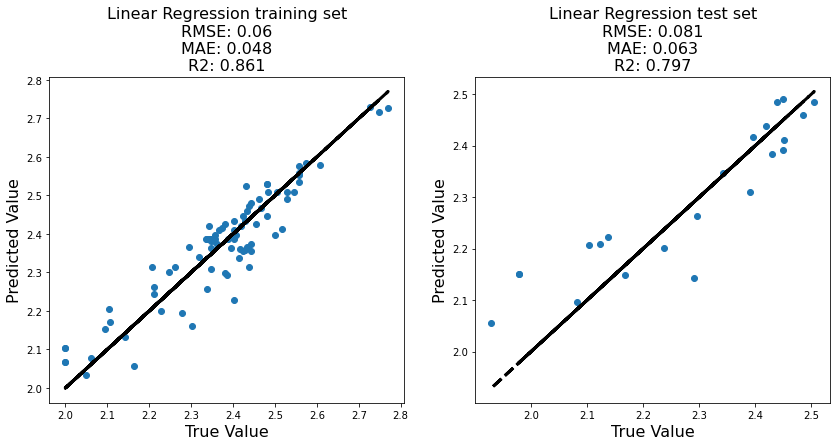

In [17]:
# create a Linear Regression regressor
lregressor = LinearRegression()

# fit and predict all the train/test arrays
lregressor.fit(X_train,y_train)
y_pred_train = lregressor.predict(X_train)
y_pred_test = lregressor.predict(X_test)

# plot the training results
rmse, mae, R2 = plot('Linear Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Linear Regression'] = rmse
mae_scores['Linear Regression'] = mae
R2_scores['Linear Regression'] = R2

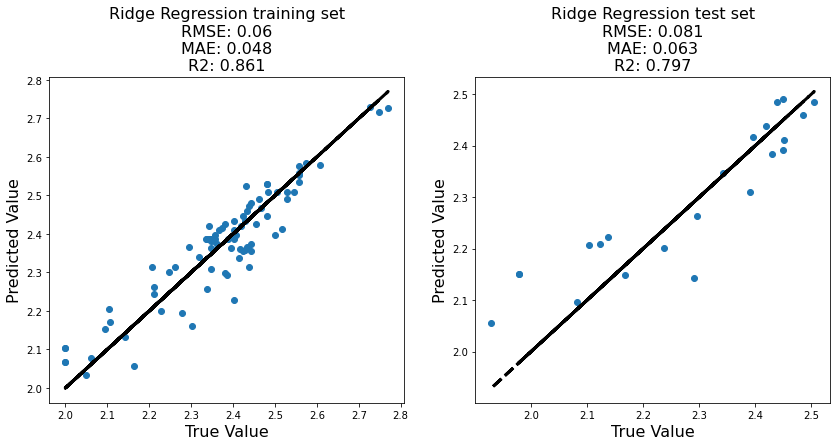

In [18]:
# RidgeCV for best alpha
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = np.logspace(-6,6,104))
ridgecv.fit(X_train, y_train)

# Ridge Regression
rregressor = Ridge(alpha = ridgecv.alpha_)

rregressor.fit(X_train,y_train)
y_pred_train = rregressor.predict(X_train)
y_pred_test = rregressor.predict(X_test)

rmse, mae, R2 = plot('Ridge Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Ridge Regression'] = rmse
mae_scores['Ridge Regression'] = mae
R2_scores['Ridge Regression'] = R2

In [19]:
# Hyperparameter for Ridge Regressor
ridgecv.alpha_

1e-06

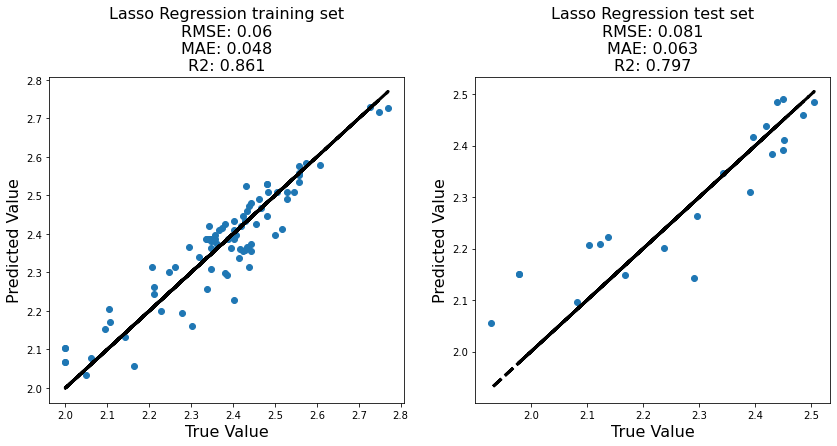

In [20]:
# LassoCV for best alpha
from sklearn.linear_model import LassoCV

y_ravel = y_train.to_numpy().ravel()

lassocv = LassoCV(alphas = np.logspace(-6,6,104))
lassocv.fit(X_train, y_ravel)

# Lasso Regression
lsregressor = Lasso(alpha = lassocv.alpha_)

lsregressor.fit(X_train,y_train)
y_pred_train = lsregressor.predict(X_train).reshape(-1,1)
y_pred_test = lsregressor.predict(X_test).reshape(-1,1)

rmse, mae, R2 = plot('Lasso Regression', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Lasso Regression'] = rmse
mae_scores['Lasso Regression'] = mae
R2_scores['Lasso Regression'] = R2

In [21]:
# Hyperparameter for Lasso Regressor
lassocv.alpha_

1e-06

In [20]:
# Hyperparameter optimization of k-Neighbors Regressor
knregressor = KNeighborsRegressor()

knr_space  = [Integer(1, 51, name='n_neighbors'),
              Categorical(categories=['auto', 'brute', 'ball_tree', 'kd_tree'], name='algorithm'),
              Integer(1, 50, name='leaf_size'),
              Integer(1, 11, name='p')]

@use_named_args(knr_space)
def objective(**params):
    knregressor.set_params(**params)
    return -np.mean(cross_val_score(knregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

knr_gp = gp_minimize(objective, knr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

In [21]:
# Hyperparameter for k-Neighbors Regressor
knr_gp.x

[5, 'auto', 1, 1]

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

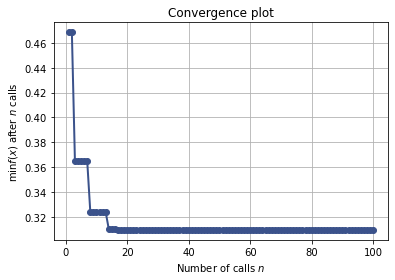

In [22]:
plot_convergence(knr_gp)

array([[<AxesSubplot:xlabel='n_neighbors', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='algorithm'>,
        <AxesSubplot:xlabel='algorithm', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='leaf_size'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='leaf_size', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_neighbors', ylabel='p'>,
        <AxesSubplot:xlabel='algorithm'>,
        <AxesSubplot:xlabel='leaf_size'>,
        <AxesSubplot:xlabel='p', ylabel='Partial dependence'>]],
      dtype=object)

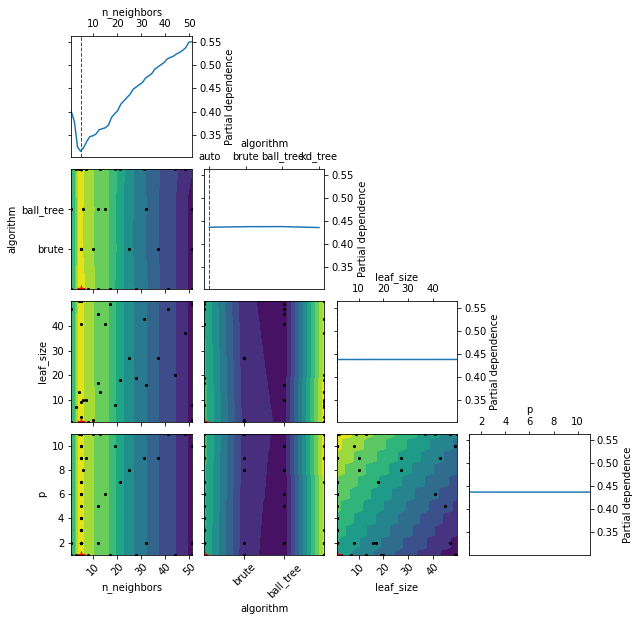

In [23]:
plot_objective(knr_gp)

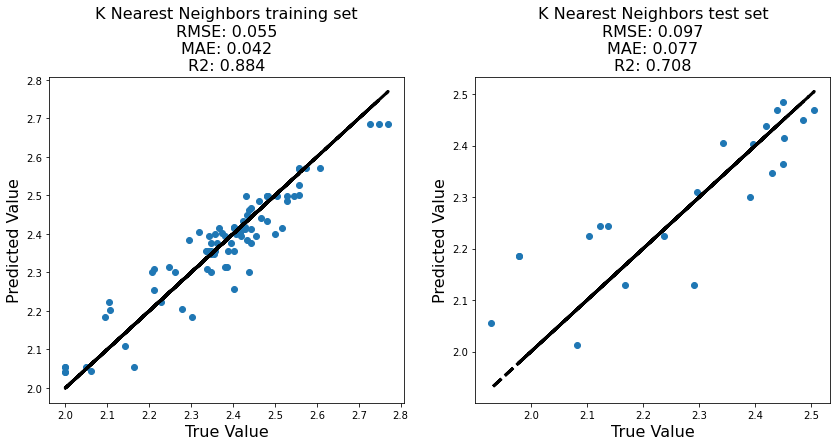

In [22]:
opt_par = knr_gp.x

# use hyper-parameters from optimization 
n_neighbors = opt_par[0]
algorithm = opt_par[1] 
p = opt_par[2]

#K-Nearest Regression
knregressor = KNeighborsRegressor(n_neighbors=n_neighbors,algorithm=algorithm,p=p)

knregressor.fit(X_train,y_train)
y_pred_train = knregressor.predict(X_train)
y_pred_test = knregressor.predict(X_test)

rmse, mae, R2 = plot('K Nearest Neighbors', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['K Nearest Neighbors'] = rmse
mae_scores['K Nearest Neighbors'] = mae
R2_scores['K Nearest Neighbors'] = R2

In [25]:
# Hyperparameter optimization of Support Vector Regressor
svregressor = SVR()

svr_space  = [Categorical(categories=['linear', 'rbf', 'sigmoid'], name='kernel'),
              Real(0.0001, 10, "log-uniform", name='gamma'),
              Real(0.01, 100, name='C')]

@use_named_args(svr_space)
def objective(**params):
    svregressor.set_params(**params)
    return -np.mean(cross_val_score(svregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

svr_gp = gp_minimize(objective, svr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

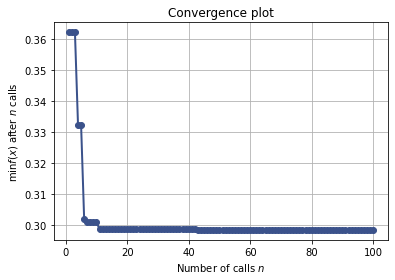

In [26]:
plot_convergence(svr_gp)

array([[<AxesSubplot:xlabel='kernel', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='gamma'>,
        <AxesSubplot:xlabel='gamma', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='kernel', ylabel='C'>,
        <AxesSubplot:xlabel='gamma'>,
        <AxesSubplot:xlabel='C', ylabel='Partial dependence'>]],
      dtype=object)

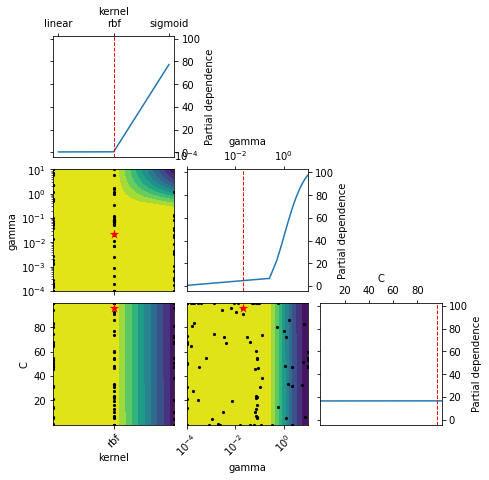

In [27]:
plot_objective(svr_gp)

In [28]:
# Hyperparameter for Support Vector Regressor
svr_gp.x

['rbf', 0.02191015191795409, 96.34187261024907]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


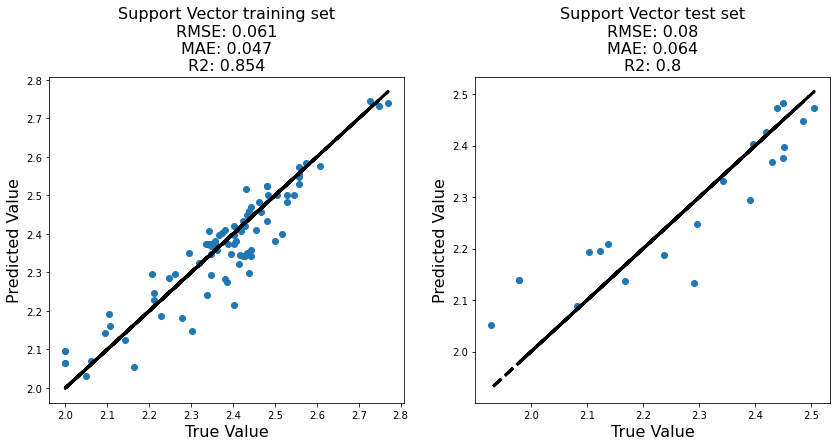

In [23]:
opt_par = svr_gp.x

# use hyper-parameters from optimization 
kernel = opt_par[0]
gamma = opt_par[1]
C = opt_par[2]

# Decision Tree Regression
svregressor = SVR(kernel=kernel, gamma=gamma, C=C)

svregressor.fit(X_train,y_train)
y_pred_train = svregressor.predict(X_train).reshape(-1, 1)
y_pred_test = svregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Support Vector', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Support Vector'] = rmse
mae_scores['Support Vector'] = mae
R2_scores['Support Vector'] = R2

In [30]:
# Hyperparameter optimization of Decision Tree Regressor
dtregressor = DecisionTreeRegressor(random_state=0)

dtr_space  = [Categorical(categories=['squared_error', 'absolute_error', 'friedman_mse'], name='criterion'),
              Categorical(categories=['best', 'random'], name='splitter'),
              Integer(1, 100, name='max_depth')]

@use_named_args(dtr_space)
def objective(**params):
    dtregressor.set_params(**params)
    return -np.mean(cross_val_score(dtregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

dtr_gp = gp_minimize(objective, dtr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

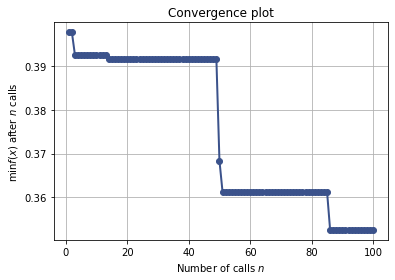

In [31]:
plot_convergence(dtr_gp)

array([[<AxesSubplot:xlabel='criterion', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='splitter'>,
        <AxesSubplot:xlabel='splitter', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='criterion', ylabel='max_depth'>,
        <AxesSubplot:xlabel='splitter'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

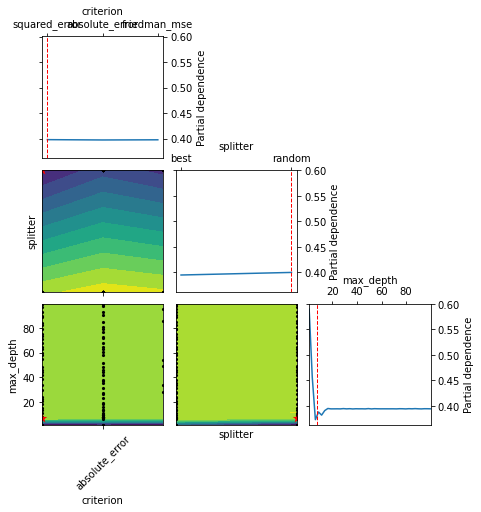

In [32]:
plot_objective(dtr_gp)

In [33]:
# Hyperparameter for Decision Tree Regressor
dtr_gp.x

['squared_error', 'random', 7]

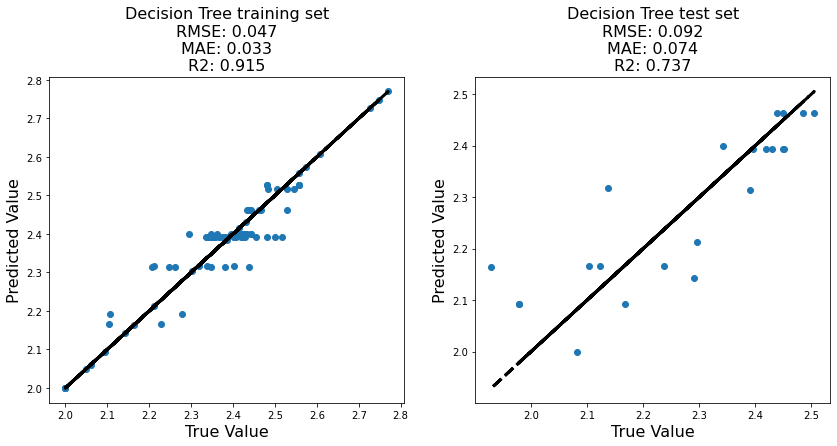

In [24]:
opt_par = dtr_gp.x

# use hyper-parameters from optimization 
criterion = opt_par[0]
splitter = opt_par[1]
max_depth = opt_par[2]

# Decision Tree Regression
dtregressor = DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, random_state=0)

dtregressor.fit(X_train,y_train)
y_pred_train = dtregressor.predict(X_train).reshape(-1, 1)
y_pred_test = dtregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Decision Tree', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Decision Tree'] = rmse
mae_scores['Decision Tree'] = mae
R2_scores['Decision Tree'] = R2

In [35]:
# Hyperparameter optimization of Gradient Boosting Regressor
gbregressor = GradientBoostingRegressor(random_state=0)

gbr_space  = [Real(0.005, 0.9, "log-uniform", name='learning_rate'),
              Categorical(categories=['squared_error', 'absolute_error', 'huber', 'quantile'], name='loss'),
              Integer(1, 1000, name='n_estimators'),
              Integer(1, 50, name='max_depth'),
              Real(0.005, 0.9, "log-uniform", name='alpha')]

@use_named_args(gbr_space)
def objective(**params):
    gbregressor.set_params(**params)
    return -np.mean(cross_val_score(gbregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

gbr_gp = gp_minimize(objective, gbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

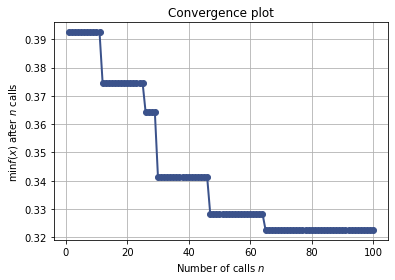

In [36]:
plot_convergence(gbr_gp)

array([[<AxesSubplot:xlabel='learning_rate', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='loss'>,
        <AxesSubplot:xlabel='loss', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='learning_rate', ylabel='alpha'>,
        <AxesSubplot:xlabel='loss'>, <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='alpha', ylabel='Partial dependence'>]],
      dtype=object)

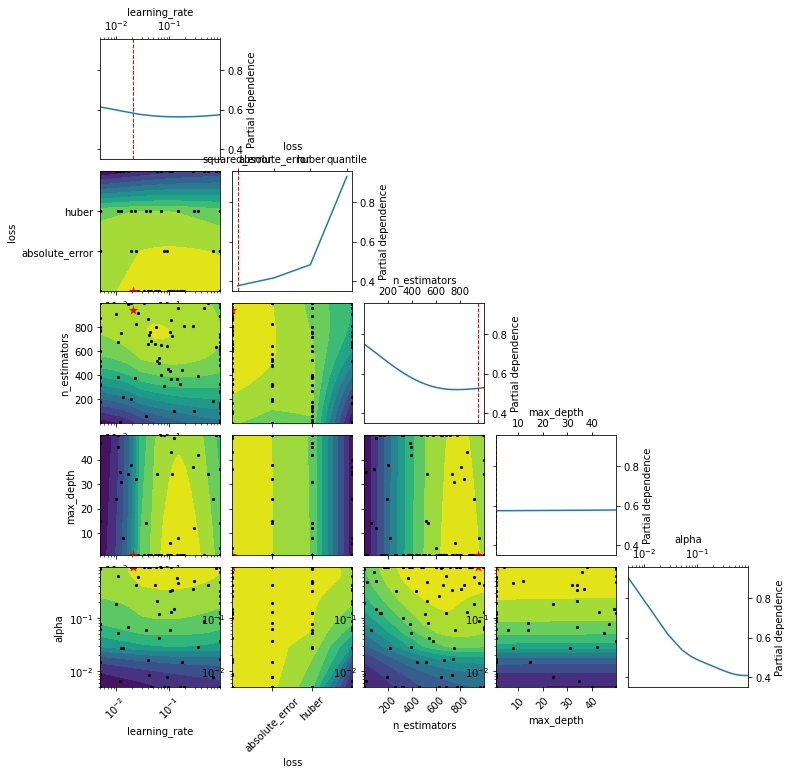

In [37]:
plot_objective(gbr_gp)

In [38]:
# Hyperparameter for Gradient Boosting Regressor
gbr_gp.x

[0.021101016070894055, 'squared_error', 947, 1, 0.8999999999999998]

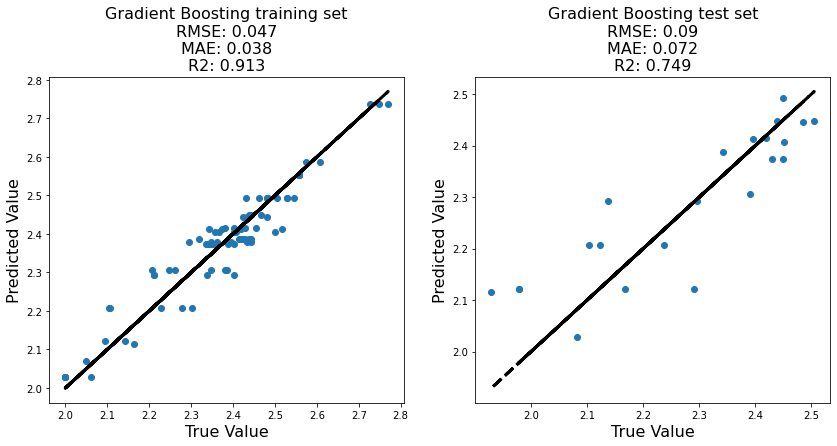

In [25]:
opt_par = gbr_gp.x

# use hyper-parameters from optimization 
learning_rate = opt_par[0]
loss = opt_par[1] 
n_estimators = opt_par[2]
max_depth = opt_par[3]
alpha = opt_par[4]

# Gradient Boosting Regression
gbregressor = GradientBoostingRegressor(n_estimators = n_estimators, learning_rate = learning_rate,
                                        max_depth = max_depth, loss = loss, alpha= alpha, random_state=0)

gbregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = gbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = gbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Gradient Boosting', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Gradient Boosting'] = rmse
mae_scores['Gradient Boosting'] = mae
R2_scores['Gradient Boosting'] = R2

In [40]:
# Hyperparameter optimization of Random Forest Regressor
rfregressor = RandomForestRegressor(random_state=0)

rfr_space  = [Integer(1, 2000, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(rfr_space)
def objective(**params):
    rfregressor.set_params(**params)
    return -np.mean(cross_val_score(rfregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

rfr_gp = gp_minimize(objective, rfr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

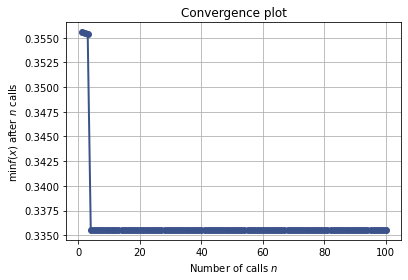

In [41]:
plot_convergence(rfr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

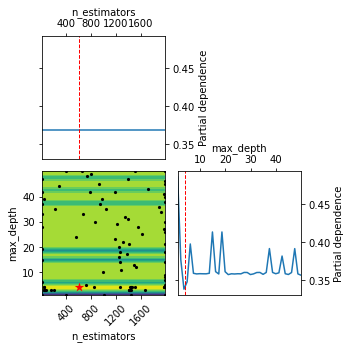

In [42]:
plot_objective(rfr_gp)

In [43]:
# Hyperparameter for Random Forest Regressor
rfr_gp.x

[596, 4]

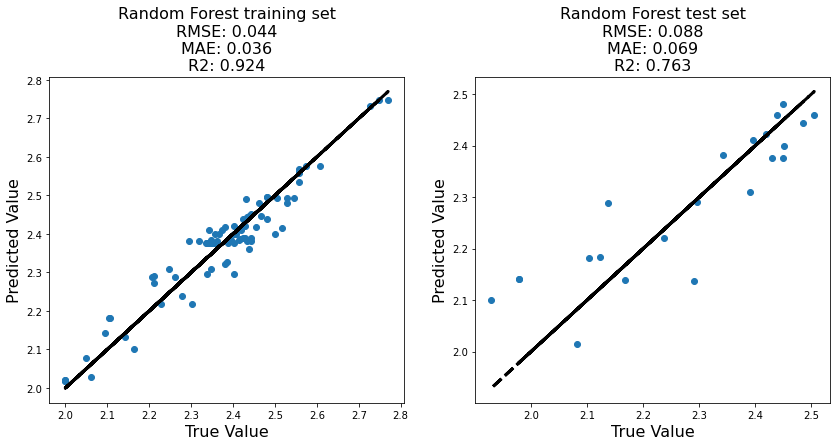

In [26]:
opt_par = rfr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Random Forest Regression
rfregressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

rfregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = rfregressor.predict(X_train).reshape(-1, 1)
y_pred_test = rfregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Random Forest', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Random Forest'] = rmse
mae_scores['Random Forest'] = mae
R2_scores['Random Forest'] = R2

In [45]:
# Hyperparameter optimization for Extra Trees Regressor
etregressor = ExtraTreesRegressor(random_state=0)

etr_space  = [Integer(1, 2000, name='n_estimators'),
              Integer(1, 50, name='max_depth')]

@use_named_args(etr_space)
def objective(**params):
    etregressor.set_params(**params)
    return -np.mean(cross_val_score(etregressor, X_train, y_train.to_numpy().ravel(), cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

etr_gp = gp_minimize(objective, etr_space, n_calls=100, n_jobs=-1, random_state=0)

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

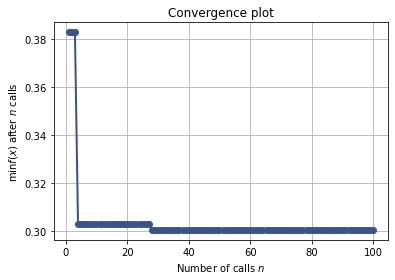

In [46]:
plot_convergence(etr_gp)

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='max_depth'>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>]],
      dtype=object)

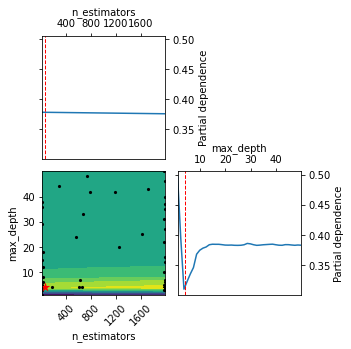

In [47]:
plot_objective(etr_gp)

In [48]:
# Hyperparameter for Extra Trees Regressor
etr_gp.x

[49, 4]

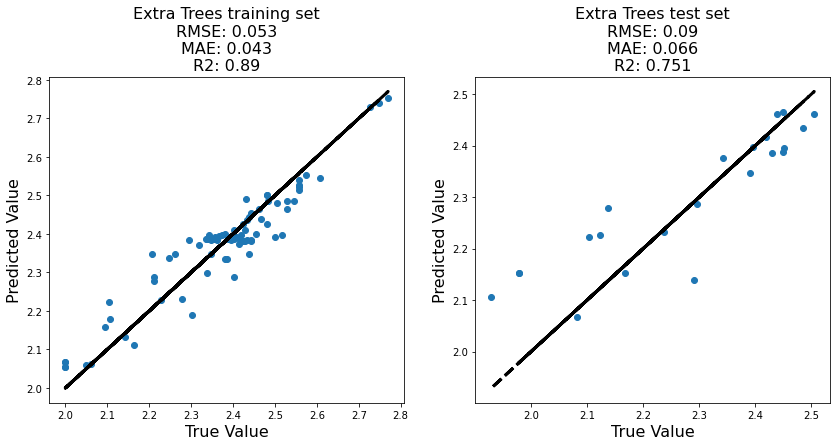

In [27]:
opt_par = etr_gp.x

# use hyper-parameters from optimization 
n_estimators = opt_par[0]
max_depth = opt_par[1]

# Extra Trees Regression
etregressor = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=0)

etregressor.fit(X_train,y_train.to_numpy().ravel())
y_pred_train = etregressor.predict(X_train).reshape(-1, 1)
y_pred_test = etregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('Extra Trees', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['Extra Trees'] = rmse
mae_scores['Extra Trees'] = mae
R2_scores['Extra Trees'] = R2

In [50]:
# Hyperparameter optimization for XGBoost Regressor
xgbregressor = XGBRegressor(random_state=0)

xgbr_space  = [Real(0.005, 1, "log-uniform", name='eta'),
              Integer(1, 200, name='n_estimators'),
              Integer(1, 20, name='max_depth'),
              Real(0.1, 1, "log-uniform", name='subsample'),
              Real(0.005, 1, "log-uniform", name='colsample_bytree')]

@use_named_args(xgbr_space)
def objective(**params):
    xgbregressor.set_params(**params)
    return -np.mean(cross_val_score(xgbregressor, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

xgbr_gp = gp_minimize(objective, xgbr_space, n_calls=100, n_jobs=-1, random_state=0)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

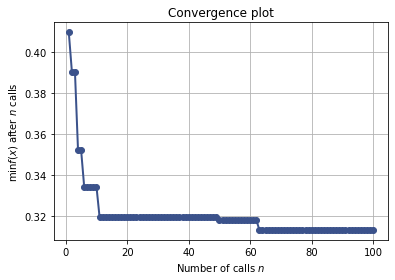

In [51]:
plot_convergence(xgbr_gp)

array([[<AxesSubplot:xlabel='eta', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='n_estimators'>,
        <AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='max_depth'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='max_depth', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='subsample'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='subsample', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='eta', ylabel='colsample_bytree'>,
        <AxesSubplot:xlabel='n_estimators'>,
        <AxesSubplot:xlabel='max_depth'>,
        <AxesSubplot:xlabel='subsample'>,
        <AxesSubplot:xlabel='colsample_bytree', ylabel='Partial dependence'>]],
      dtype=object)

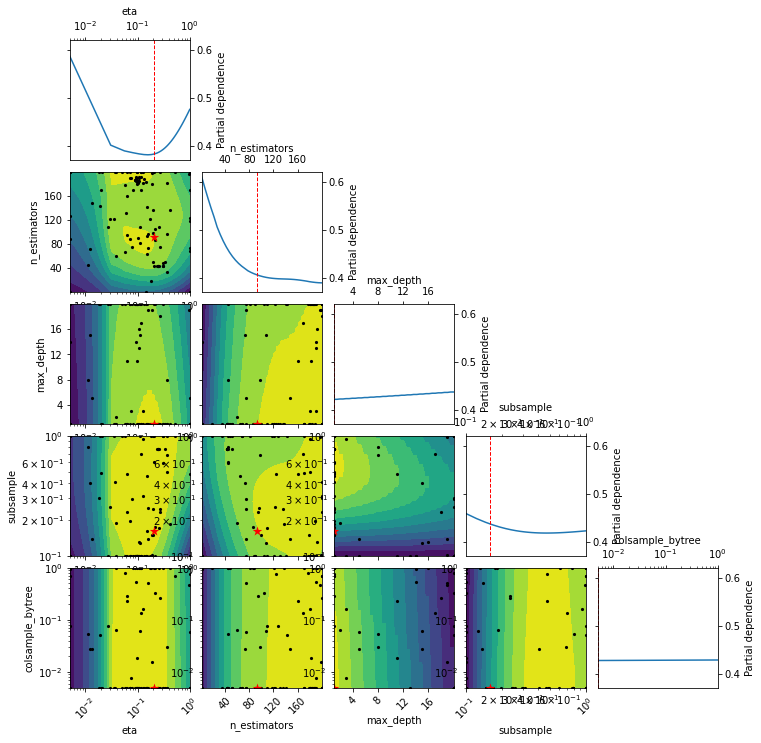

In [52]:
plot_objective(xgbr_gp)

In [53]:
# Hyperparameter for XGBoost Regressor
xgbr_gp.x

[0.2052298956006802, 92, 1, 0.1604943361723051, 0.005]

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


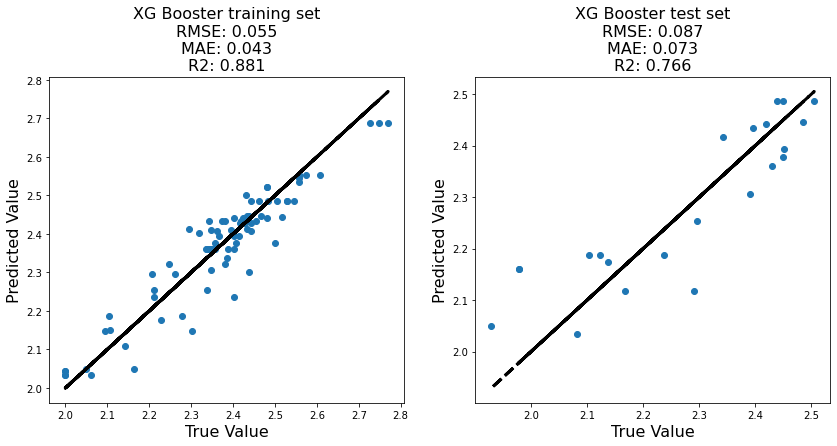

In [28]:
opt_par = xgbr_gp.x

# use hyper-parameters from optimization
eta= opt_par[0]
n_estimators = opt_par[1]
max_depth = opt_par[2]
subsample = opt_par[3]
colsample_bytree = opt_par[4]

#XGBoost Regression
xgbregressor = XGBRegressor(eta=eta, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample,
                            colsample_bytree=colsample_bytree, random_state=0)
    
xgbregressor.fit(X_train,y_train)
y_pred_train = xgbregressor.predict(X_train).reshape(-1, 1)
y_pred_test = xgbregressor.predict(X_test).reshape(-1, 1)

rmse, mae, R2 = plot('XG Booster', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['XG Booster'] = rmse
mae_scores['XG Booster'] = mae
R2_scores['XG Booster'] = R2

In [29]:
# Importing libraries for Neural Network Regression
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization

In [30]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with same number of units in hidden layers
class MyHyperModel(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=10, step=1)
        units = hp.Int('units', min_value=16, max_value=1024, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(num_dense_layers = num_dense_layers,
                      units=units,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        for i in range(params['num_dense_layers']):
            name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
            model.add(Dense(units=params['units'],activation=params['activation'], name=name)) #add hidden layer(s)
            model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # 3 types of optimizers are used for finding the best suited with best learning rate
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=64, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [31]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner = kt.Hyperband(MyHyperModel(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=100, factor=3,
                     overwrite=False, #in case of reloading the trial runs results
                     directory=os.path.normpath('logTS-HV_keras_tuner_Hyb'), project_name='first_run')

In [32]:
tuner.search(X_train, y_train)

Trial 254 Complete [00h 00m 08s]
val_loss: 0.8254196047782898

Best val_loss So Far: 0.29433250427246094
Total elapsed time: 00h 10m 16s
INFO:tensorflow:Oracle triggered exit


In [33]:
tuner.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\ms2-ML\logTS-HV_keras_tuner_Hyb\first_run
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_dense_layers: 9
units: 942
activation: tanh
learning_rate: 0.00016332987431980748
optimizer: RMSprop
batch_size: 45
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.29433250427246094
Trial summary
Hyperparameters:
num_dense_layers: 6
units: 415
activation: elu
learning_rate: 0.001172556665655592
optimizer: Adam
batch_size: 56
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: a7725a1af0573c3347293bd09e282148
Score: 0.29680848121643066
Trial summary
Hyperparameters:
num_dense_layers: 5
units: 182
activation: relu
learning_rate: 0.012865497087049508
optimizer: Adam
batch_size: 37
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 6e3aa15fb059e0ec3ed830d3bb3a9925
Score: 0.30185064673423767
T

In [34]:
# Printing the best hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

for h_param in ['num_dense_layers', 'units', 'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

num_dense_layers 9
units 942
activation tanh
learning_rate 0.00016332987431980748
optimizer RMSprop
batch_size 45
tuner/epochs 4


In [35]:
# Storing the hyperparameters in variables to develop the NN architecture
num_dense_layers = best_hps.get('num_dense_layers')
units = best_hps.get('units')
activation = best_hps.get('activation')
learning_rate = best_hps.get('learning_rate')
optimizer = best_hps.get('optimizer')
batch_size = best_hps.get('batch_size')
epochs = best_hps.get('tuner/epochs')

In [36]:
# function to develop NN architecture with same number of units in all hidden layers
def build_and_compile_model(num_dense_layers,units,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1) #name of hidden layer
        model.add(Dense(units,activation=activation,name=name)) #add hidden layer(s)
        model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [47]:
# Create the neural network with these hyper-parameters.
model1 = build_and_compile_model(num_dense_layers, units, activation, learning_rate, optimizer)

# Train the model.
history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

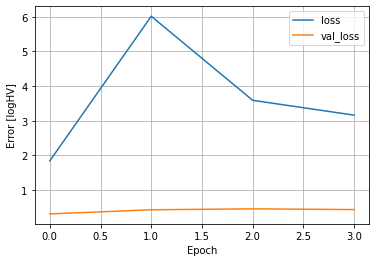

In [48]:
# function to plot the training and validation history of the NN
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [logHV]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [49]:
print('Mean Absolute Error (logHV), Mean Squared Error (logHV): ', model1.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logHV), Mean Squared Error (logHV):  [0.48521721363067627, 0.37924128770828247]


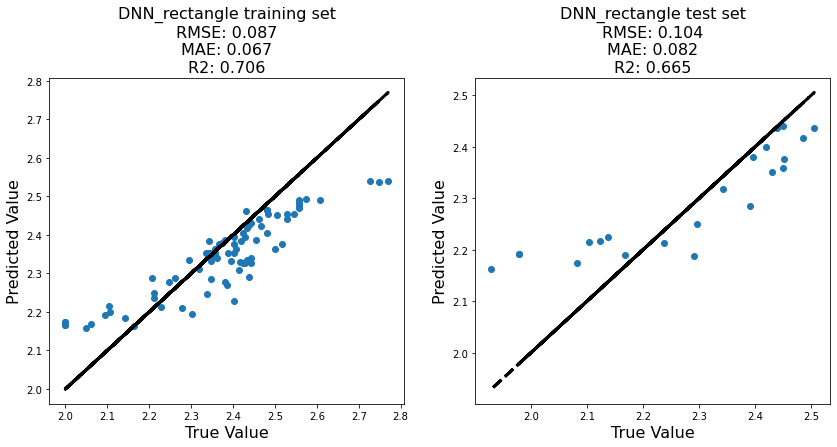

In [50]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model1.predict(X_train)
y_pred_test=model1.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('DNN_rectangle', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['DNN_rectangle'] = rmse
mae_scores['DNN_rectangle'] = mae
R2_scores['DNN_rectangle'] = R2

In [60]:
# Defining Hypermodel object to optimize hyperparameters for Neural Network Regression architecture with different number of units in different hidden layers
class MyHyperModel2(kt.HyperModel):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def build(self, hp):
        units_1 = hp.Int('units_1', min_value=16, max_value=1024, step=1)
        units_2 = hp.Int('units_2', min_value=16, max_value=1024, step=1)
        units_3 = hp.Int('units_3', min_value=16, max_value=1024, step=1)
        units_4 = hp.Int('units_4', min_value=16, max_value=1024, step=1)
        units_5 = hp.Int('units_5', min_value=16, max_value=1024, step=1)
        units_6 = hp.Int('units_6', min_value=16, max_value=1024, step=1)
        units_7 = hp.Int('units_7', min_value=16, max_value=1024, step=1)
        units_8 = hp.Int('units_8', min_value=16, max_value=1024, step=1)
        units_9 = hp.Int('units_9', min_value=16, max_value=1024, step=1)
        activation = hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid'])
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
        optimizer = hp.Choice('optimizer', values=['Adam', 'SGD', 'RMSprop'])
        
        params = dict(units_1=units_1,
                      units_2=units_2,
                      units_3=units_3,
                      units_4=units_4,
                      units_5=units_5,
                      units_6=units_6,
                      units_7=units_7,
                      units_8=units_8,
                      units_9=units_9,
                      activation = activation,
                      lr = lr,
                      optimizer=optimizer)
        
        model = Sequential()
        model.add(InputLayer(input_shape=(self.X.shape[1],))) #Input Layer with training feature data shape
        model.add(BatchNormalization())
        # The number of hidden layers are same as previous NN architecture
        model.add(Dense(units=params['units_1'],activation=params['activation'], name='layers_dense_1')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_2'],activation=params['activation'], name='layers_dense_2')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_3'],activation=params['activation'], name='layers_dense_3')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_4'],activation=params['activation'], name='layers_dense_4')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_5'],activation=params['activation'], name='layers_dense_5')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_6'],activation=params['activation'], name='layers_dense_6')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_7'],activation=params['activation'], name='layers_dense_7')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_8'],activation=params['activation'], name='layers_dense_8')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(units=params['units_9'],activation=params['activation'], name='layers_dense_9')) #add hidden layer(s)
        model.add(BatchNormalization())
        model.add(Dense(1, activation='linear')) #final layer before output layer
        # 3 types of optimizers are used for finding the best suited with best learning rate
        if params['optimizer'] == 'Adam':
            opt = keras.optimizers.Adam(learning_rate=params['lr'])
        if params['optimizer'] == 'SGD':
            opt = keras.optimizers.SGD(learning_rate=params['lr'])
        if params['optimizer'] == 'RMSprop':
            opt = keras.optimizers.RMSprop(learning_rate=params['lr'])
        model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         batch_size = hp.Int('batch_size', min_value=8, max_value=64, step=1),
                         #epochs = hp.Int('epochs', min_value=10, max_value=100, step=1),
                         validation_split=0.2,
                         **kwargs,)

In [63]:
# Hyperband Optimization from Keras-Tuner is used for hyperparameter optimization and the complete search space is stored in the working folder
import os
tuner2 = kt.Hyperband(MyHyperModel2(X_train,y_train),
                     objective=kt.Objective("val_loss",direction="min"), max_epochs=100, factor=3,
                     overwrite=True, #in case of reloading the trial runs results
                     directory=os.path.normpath('logTS-HV_keras_tuner_Hyb'), project_name='first_run_random')

In [64]:
tuner2.search(X_train, y_train)

Trial 254 Complete [00h 00m 10s]
val_loss: 0.5220702290534973

Best val_loss So Far: 0.285996675491333
Total elapsed time: 00h 16m 09s
INFO:tensorflow:Oracle triggered exit


In [65]:
tuner2.results_summary()

Results summary
Results in C:\Users\shakt\Desktop\ms2-ML\logTS-HV_keras_tuner_Hyb\first_run_random
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_1: 834
units_2: 638
units_3: 636
units_4: 450
units_5: 435
units_6: 733
units_7: 668
units_8: 872
units_9: 647
activation: elu
learning_rate: 0.00031217638288076046
optimizer: RMSprop
batch_size: 9
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: e50a73dd23a9b04c205141e1924b4ee4
Score: 0.285996675491333
Trial summary
Hyperparameters:
units_1: 850
units_2: 627
units_3: 540
units_4: 1020
units_5: 589
units_6: 390
units_7: 330
units_8: 217
units_9: 808
activation: elu
learning_rate: 0.0012646990347951552
optimizer: Adam
batch_size: 56
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: e724e1b1a3e624ea61b62bd974128cf5
Score: 0.3185485005378723
Trial summary
Hyperparameters:
units_1: 834
units_2: 638
units_3: 636


In [66]:
# Printing the best hyperparameters
best_hps_2=tuner2.get_best_hyperparameters()[0]

for h_param in ['units_1', 'units_2', 'units_3', 'units_4', 'units_5', 'units_6', 'units_7', 'units_8', 'units_9',
'activation', 'learning_rate', 'optimizer', 'batch_size', 'tuner/epochs']:
    print(h_param, tuner2.get_best_hyperparameters()[0].get(h_param))

units_1 834
units_2 638
units_3 636
units_4 450
units_5 435
units_6 733
units_7 668
units_8 872
units_9 647
activation elu
learning_rate 0.00031217638288076046
optimizer RMSprop
batch_size 9
tuner/epochs 100


In [67]:
# Storing the hyperparameters in variables to develop the NN architecture
units_1 = best_hps_2.get('units_1')
units_2 = best_hps_2.get('units_2')
units_3 = best_hps_2.get('units_3')
units_4 = best_hps_2.get('units_4')
units_5 = best_hps_2.get('units_5')
units_6 = best_hps_2.get('units_6')
units_7 = best_hps_2.get('units_7')
units_8 = best_hps_2.get('units_8')
units_9 = best_hps_2.get('units_9')
activation = best_hps_2.get('activation')
learning_rate = best_hps_2.get('learning_rate')
optimizer = best_hps_2.get('optimizer')
batch_size = best_hps_2.get('batch_size')
epochs = best_hps_2.get('tuner/epochs')

In [68]:
# function to develop NN architecture with different number of units in different hidden layers
def compile_model(units_1,units_2,units_3,units_4,units_5,units_6,units_7,units_8,units_9,activation,lr,optimizer):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1],))) #Input Layer with training feature data shape
    model.add(BatchNormalization())
    name = 'layer_dense_1'#name of hidden layer
    model.add(Dense(units_1, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_2'#name of hidden layer
    model.add(Dense(units_2, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_3'#name of hidden layer
    model.add(Dense(units_3, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_4'#name of hidden layer
    model.add(Dense(units_4, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_5'#name of hidden layer
    model.add(Dense(units_5, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_6'#name of hidden layer
    model.add(Dense(units_6, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_7'#name of hidden layer
    model.add(Dense(units_7, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_8'#name of hidden layer
    model.add(Dense(units_8, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    name = 'layer_dense_9'#name of hidden layer
    model.add(Dense(units_9, activation=activation, name=name)) #add hidden layer(s)
    model.add(BatchNormalization())
    model.add(Dense(1, activation='linear')) #final layer before output layer
    if optimizer == 'Adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    if optimizer == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    if optimizer == 'RMSprop':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mean_squared_error'])
    return model

In [111]:
# Create the neural network with these hyper-parameters.
model2 = compile_model(units_1,units_2,units_3,units_4,units_5,units_6,units_7,units_8,units_9,activation,learning_rate,optimizer)
    
# Train the model.
history = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

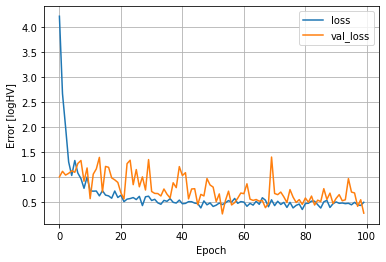

In [112]:
plot_loss(history)

In [113]:
print('Mean Absolute Error (logHV), Mean Squared Error (logHV): ', model2.evaluate(X_test, y_test, verbose=0))

Mean Absolute Error (logHV), Mean Squared Error (logHV):  [0.44317132234573364, 0.31494012475013733]


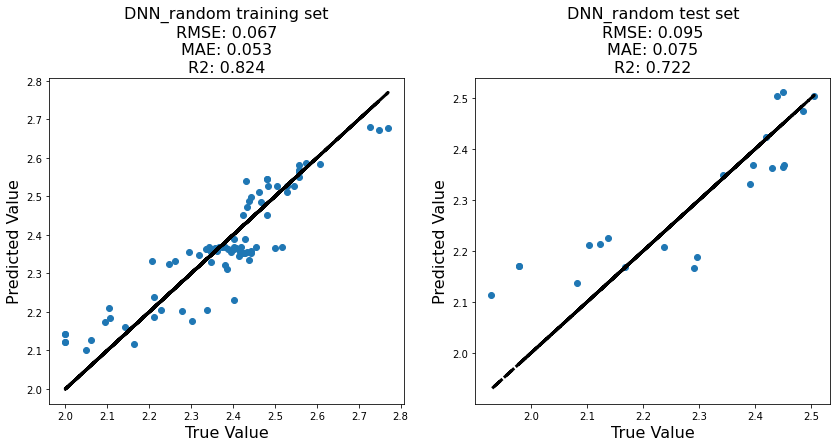

In [114]:
# Use the trained Keras model to predict on the training and test sets
y_pred_train=model2.predict(X_train)
y_pred_test=model2.predict(X_test)

# Plot the training results
rmse, mae, R2 = plot('DNN_random', y_train, y_pred_train, y_test, y_pred_test)

rmse_scores['DNN_random'] = rmse
mae_scores['DNN_random'] = mae
R2_scores['DNN_random'] = R2

In [115]:
# Creating dataframe of the metrics of the 12 regressors used 
rmse = pd.DataFrame(list(rmse_scores.items()),columns = ['Regressor','RMSE'])
mae = pd.DataFrame(list(mae_scores.items()),columns = ['Regressor','MAE'])
r2 = pd.DataFrame(list(R2_scores.items()),columns = ['Regressor','R2'])
scores_df = pd.concat([rmse,mae.iloc[:,1],r2.iloc[:,1]],axis=1)
scores_df

,Regressor,RMSE,MAE,R2
0,Linear Regression,0.081,0.063,0.797
1,Ridge Regression,0.081,0.063,0.797
2,Lasso Regression,0.081,0.063,0.797
3,K Nearest Neighbors,0.097,0.077,0.708
4,Support Vector,0.080,0.064,0.800
5,Decision Tree,0.092,0.074,0.737
6,Gradient Boosting,0.090,0.072,0.749
7,Random Forest,0.088,0.069,0.763
8,Extra Trees,0.090,0.066,0.751
9,XG Booster,0.087,0.073,0.766


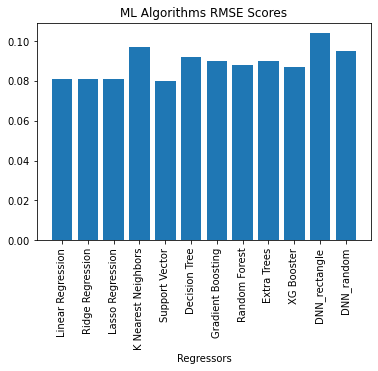

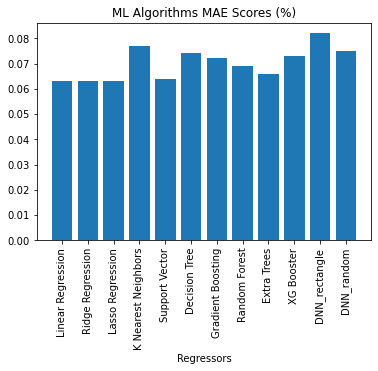

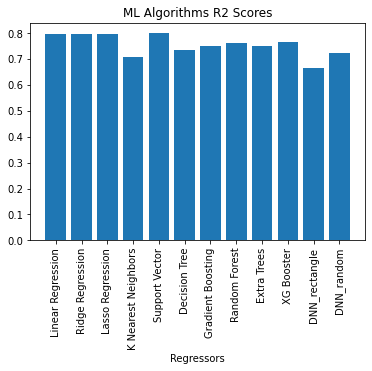

In [116]:
# Plotting the bar graph of the 3 metrics for all the models
plt.bar(range(len(rmse_scores.values())),list(rmse_scores.values()),  
        tick_label=list(rmse_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms RMSE Scores')
plt.show()

plt.bar(range(len(mae_scores.values())),list(mae_scores.values()),  
        tick_label=list(mae_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms MAE Scores (%)')
plt.show()

plt.bar(range(len(R2_scores.values())),list(R2_scores.values()),  
        tick_label=list(R2_scores.keys()))
plt.xticks(rotation='vertical')
plt.xlabel('Regressors')
plt.title('ML Algorithms R2 Scores')
plt.show()

In [117]:
# Exporting the performance metric results
scores_df.to_excel('Scores_logHV-logTS.xlsx')

# Imputation

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TS      244 non-null    float64
 1   HV      175 non-null    float64
dtypes: float64(2)
memory usage: 19.0 KB


In [31]:
# Creating a database with non-null tensile strength entries and respective indices Vickers hardness entries
df1 = np.log10(df[df['TS'].notnull()])
df1

,TS,HV
202,2.614897,2.000000
222,3.079904,2.481443
247,2.697229,1.977724
280,2.753583,2.103804
302,2.650308,2.000000
...,...,...
1162,2.748188,2.238046
1163,3.271842,NaN
1164,3.225309,NaN
1165,3.217484,NaN


In [32]:
# Predicting HV from TS for all the above indices using the best model
X_imp = df1.iloc[:,:-1]
X_transform = scalerX.transform(X_imp)
y_imp_transform = lregressor.predict(X_transform)
HV_imp = pd.DataFrame(10**(scalerY.inverse_transform(y_imp_transform.reshape(-1, 1))),columns=["HV"],index=df1.index)
HV_imp = HV_imp.round(decimals=2)
HV_imp

c:\Users\shakt\anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,HV
202,117.09
222,339.19
247,141.36
280,160.80
302,126.97
...,...
1162,158.83
1163,526.14
1164,473.02
1165,464.63


In [33]:
# Filling up the empty cell with predicted HV values
df.HV = df.HV.fillna(HV_imp.HV)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TS      244 non-null    float64
 1   HV      313 non-null    float64
dtypes: float64(2)
memory usage: 19.0 KB


In [34]:
# Creating a database with imputed Ms, Hc, Tc, ER, Elong & HV (from TS) values
new_db = pd.concat([db.iloc[:,:22],df.iloc[:,-1],db.iloc[:,23]], axis=1)
new_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fe      1208 non-null   float64
 1   Co      1208 non-null   float64
 2   Ni      1208 non-null   float64
 3   V       1208 non-null   float64
 4   Mo      1208 non-null   float64
 5   Cr      1208 non-null   float64
 6   Cu      1208 non-null   float64
 7   Mn      1208 non-null   float64
 8   C       1208 non-null   float64
 9   W       1208 non-null   float64
 10  Ta      1208 non-null   float64
 11  Nb      1208 non-null   float64
 12  Al      1208 non-null   float64
 13  Ti      1208 non-null   float64
 14  Si      1208 non-null   float64
 15  Ms      1208 non-null   float64
 16  Hc      1208 non-null   float64
 17  Tc      1208 non-null   float64
 18  ER      1208 non-null   float64
 19  TS      244 non-null    float64
 20  YS      239 non-null    float64
 21  Elong   1208 non-null   float64
 22  

In [35]:
# Exporting the imputed database by specifying the imputation from TS in the file name
new_db.to_csv('FeNiCo_comp-prop_imp_after HV-TS.csv')